# 1. Setup environment

## 1.1 Install dependencies

In [1]:
# !pip install tensorflow==2.13.0 opencv-python matplotlib

## 1.2 Import dependencies

In [2]:
import numpy as np
import os
import pathlib
import datetime

import matplotlib.pyplot as plt
from matplotlib import patches
# from matplotlib.collections import PatchCollection
# from matplotlib import cm
# from matplotlib import animation

In [3]:
# # Load the TensorBoard notebook extension
# %load_ext tensorboard

# Importing Tensorflow - Funcitonal API
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, Dropout, MaxPooling2D, Input, Flatten, BatchNormalization
# Import Metric calculation
from tensorflow.keras.metrics import Precision, Recall
#
import tensorflow as tf

2023-07-16 11:23:15.873847: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-16 11:23:15.991796: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-16 11:23:16.478472: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/extras/CUPIT/lib64:/usr/local/cuda/lib64:/home/paco/miniconda3/envs/tf/

In [4]:
# Set general options
np.set_printoptions(precision=8)
# tf.keras.backend.set_floatx('float64')

# %tensorboard --logdir logs/fit

## 1.3 Limit GPU growth

In [5]:
# Avoid Out of Memory (OOM) errors by setting GPU Memory Consuption Growth
# Without this, by default tensorflow uses all memory available
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    
# Print Tensorflow version and GPU available
print("Tensorflow Version: {}".format(tf.__version__))
print(tf.config.list_physical_devices('GPU'))
print(tf.config.list_logical_devices('GPU'))

2023-07-16 11:23:17.188709: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-16 11:23:17.192596: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-16 11:23:17.192689: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-16 11:23:17.195137: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Tensorflow Version: 2.11.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2023-07-16 11:23:17.195273: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-16 11:23:17.195341: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-16 11:23:17.736652: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-16 11:23:17.736945: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-16 11:23:17.737033: I tensorflow/compiler/xla/stream_executo

# 2. Load and preprocess Dataset

## 2.1 Get training image paths

In [6]:
# Create a Tensorflow Dataset through list_files
dataset_dir = tf.data.Dataset.list_files('dataset/*.jpg', shuffle=True)

In [7]:
# Look one sample
dir_test = dataset_dir.as_numpy_iterator()
dir_test.next()

b'dataset/fe2e8292-2319-11ee-b014-b0a460e43478.jpg'

## 2.2 Define a preprocessing function

In [8]:
# Define a function to load the image and resize it and its label (ground truth)
@tf.function
def preprocess_path_rgb(file_path):
    '''
    Function that converts a file path to a normalized `(img, [xc, yc, x1, y1, x2, y2, xv, yv])` pair:
    '''
    # Get coordinates (xc, yc, radius) from annotation file
    annotation_file = tf.strings.regex_replace(file_path, ".jpg", ".txt", replace_global=True, name=None)
    # Read annotation file
    y_true = tf.io.read_file(annotation_file)
    # Take all until -2
    y_true = tf.strings.substr(y_true, 0, 87)
    # Decode as columns (already normalized)
    y_true = tf.io.decode_csv(y_true, record_defaults=[np.float64(), np.float64(), np.float64(), np.float64(),
                                                       np.float64(), np.float64(), np.float64(), np.float64()], field_delim=',')
    #
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # Resize the image to the desired size of 100x100x3
    img = tf.image.resize(img, [200, 200])
    # Scaling image to be between 0 and 1
    img = img / 255.0
    
    # Return the image
    return img, y_true

(-0.5, 199.5, 199.5, -0.5)

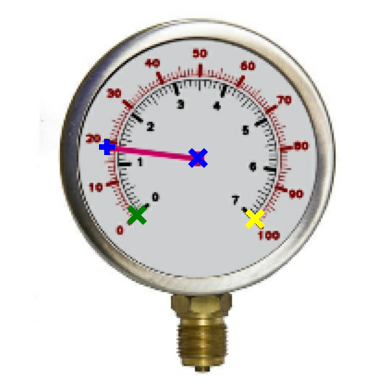

In [9]:
# Network Image Size
net_img_size = 200
# Plot an example
sample = preprocess_path_rgb(dir_test.next())
plt.imshow(sample[0])
# Plot center
plt.plot(int(sample[1][0] * net_img_size), int(sample[1][1] * net_img_size), color='blue', marker='x', linewidth=2, 
         markersize=12, markeredgewidth=4)
# Plot Mark 1 - Minimum at scale (x1, y1)
plt.plot(int(sample[1][2] * net_img_size), int(sample[1][3] * net_img_size), color='green', marker='x', linewidth=2, 
         markersize=12, markeredgewidth=4)
# Plot Mark 2 - Maximum at scale (x2, y2)
plt.plot(int(sample[1][4] * net_img_size), int(sample[1][5] * net_img_size), color='yellow', marker='x', linewidth=2, 
         markersize=12, markeredgewidth=4)
# Plot Gauge Mark - Point of the tail (xv, yv)
plt.plot(int(sample[1][6] * net_img_size), int(sample[1][7] * net_img_size), color='blue', marker='+', linewidth=2, 
         markersize=12, markeredgewidth=4)
# Do not display the axis
plt.axis('off')

## 2.3 Create labelled dataset

In [10]:
# Build pipeline
dataset = dataset_dir.map(preprocess_path_rgb)
dataset = dataset.cache()
dataset = dataset.shuffle(buffer_size=1024)

## 2.4 Create train and test partition

In [11]:
# Training partition 70%
split_100 = 0.7
train_partition = dataset.take(round(len(dataset_dir) * split_100))
# train_data = dataset.take(round(len(dataset_dir) * split_100))
# train_data = train_data.batch(16)
# train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE) # 8)  

In [12]:
# Testing partition 30%
test_data = dataset.skip(round(len(dataset_dir) * split_100))
test_data = test_data.take(round(len(dataset_dir) * (1-split_100)))
test_data = test_data.batch(16)
test_data = test_data.prefetch(buffer_size=tf.data.AUTOTUNE) # 8)  

In [13]:
# This partition will be 80% for training and 20% for validation
split_train_100 = 0.8
train_data = train_partition.take(round(len(train_partition) * split_train_100))
train_data = train_data.batch(16)
train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE) # 8)
# Validation data
validation_data = train_partition.skip(round(len(train_partition) * split_train_100))
validation_data = validation_data.take(round(len(train_partition) * (1-split_train_100)))
validation_data = validation_data.batch(16)
validation_data = validation_data.prefetch(buffer_size=tf.data.AUTOTUNE) # 8) 

# 3. Model Creation

## 3.1 Structure

In [14]:
def uncompiled_model():
    # Input
    inp = keras.Input(shape=(200, 200, 3), name="input_image")  # 200x200x3 RGB images
    #
    # ===========================================
    # Backbone - Feature Extractions - Classifier
    # ===========================================
    # First Block
    c1  = Conv2D(64, (10, 10), activation='relu')(inp)
    bn1 = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(c1)
    m1  = MaxPooling2D(64, (2, 2), padding='same')(c1)
    # Second Block
    c2  = Conv2D(128, (7, 7), activation='relu')(m1)
    bn2 = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(c2)
    m2  = MaxPooling2D(64, (2, 2), padding='same')(c2)
    # Third Block
    c3  = Conv2D(128, (4, 4), activation='relu')(m2)
    bn3 = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(c3)
    m3  = MaxPooling2D(64, (2, 2), padding='same')(c3)
    # Final embedding block
    c4 = Conv2D(256, (4, 4), activation='relu')(m3)
    backbone = Flatten()(c4)
    #
    # # Time to apply global max pooling.
    # backbone = layers.GlobalMaxPooling2D()(backbone)
    #
    # # Flatten
    # backbone = layers.Flatten()(d1)
    #
    # ===================================
    # Head - Circle parameters Regression
    # ===================================
    d1 = Dense(1024, activation='linear', name="head_fc1")(backbone)
    d2 = Dense(1024, activation="relu", name="head_fc2")(d1)
    # dp1 = Dropout(0.4, name="dropout1")(d2)
    out  = Dense(8, activation="linear", name="head_predictions")(d2)  # , kernel_regularizer='l1_l2', name="head_predictions")(head)
    #
    # Generate and return the model
    model = keras.Model(inputs=[inp], outputs=[out], name="gauge_value_estimator")
    return model

In [15]:
model = uncompiled_model()
model.summary()

Model: "gauge_value_estimator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 200, 200, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 191, 191, 64)      19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 96, 96, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 42, 42, 1

# 4. Training

## 4.1 Compile Model - Setup Loss and Optimizer

In [16]:
# Define optimizer
model_opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
# Define Loss
model_loss = tf.keras.losses.MeanSquaredError() # reduction='sum_over_batch_size')

In [24]:
# Compile
model.compile(
    optimizer=model_opt,
    # Loss function to minimize
    loss=model_loss,
    # List of metrics to monitor
    # metrics=[keras.metrics.Accuracy()],
    metrics=['accuracy']
)

## 4.2 Establish Checkpoints

In [25]:
checkpoint_dir = './training_checkpoints/'
# checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
# checkpoint = tf.train.Checkpoint(optimizer=model_opt, model=model)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_dir,
    monitor='val_accuracy',
    save_weights_only=True,
    save_best_only=False,
    save_freq=len(train_data), #save_frequency_in_batch, #'epoch',
    verbose=1
)

# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [19]:
# %tensorboard --logdir logs/fit

## 4.3 Train the model

In [26]:
history = model.fit(
    train_data,
    validation_data=validation_data,
    batch_size=16,
    verbose=2,
    shuffle=True,
    epochs=100,
    callbacks=[cp_callback]  # Pass callback to training
)

Epoch 1/100

Epoch 1: saving model to ./training_checkpoints/
35/35 - 14s - loss: 7.3495e-05 - accuracy: 0.9893 - val_loss: 7.1724e-05 - val_accuracy: 0.9929 - 14s/epoch - 388ms/step
Epoch 2/100

Epoch 2: saving model to ./training_checkpoints/
35/35 - 13s - loss: 4.5202e-05 - accuracy: 0.9839 - val_loss: 3.5738e-05 - val_accuracy: 0.9929 - 13s/epoch - 377ms/step
Epoch 3/100

Epoch 3: saving model to ./training_checkpoints/
35/35 - 13s - loss: 4.5471e-05 - accuracy: 0.9857 - val_loss: 4.3982e-05 - val_accuracy: 1.0000 - 13s/epoch - 377ms/step
Epoch 4/100

Epoch 4: saving model to ./training_checkpoints/
35/35 - 13s - loss: 4.5014e-05 - accuracy: 0.9929 - val_loss: 2.6602e-05 - val_accuracy: 1.0000 - 13s/epoch - 375ms/step
Epoch 5/100

Epoch 5: saving model to ./training_checkpoints/
35/35 - 13s - loss: 4.8540e-05 - accuracy: 0.9786 - val_loss: 1.4001e-04 - val_accuracy: 0.9929 - 13s/epoch - 375ms/step
Epoch 6/100

Epoch 6: saving model to ./training_checkpoints/
35/35 - 13s - loss: 6.2

In [21]:
# Get a batch of test data
test_input, y_true = test_data.as_numpy_iterator().next()

In [22]:
# Make predictions
y_hat = model.predict([test_input])
y_hat

1/1 [==============================] - 0s 81ms/step


array([[0.5152528 , 0.40916342, 0.3458574 , 0.56707746, 0.6690805 ,
        0.5780873 , 0.72061163, 0.52342284],
       [0.51290876, 0.4078491 , 0.34605137, 0.5650392 , 0.6675799 ,
        0.5750837 , 0.39129093, 0.19327322],
       [0.51348406, 0.40708032, 0.34370312, 0.5650181 , 0.6674175 ,
        0.57497984, 0.57832295, 0.17041187],
       [0.5122715 , 0.40693933, 0.34352258, 0.56318945, 0.665339  ,
        0.5746578 , 0.6263362 , 0.1845799 ],
       [0.5161944 , 0.4096361 , 0.34689164, 0.5671536 , 0.6719223 ,
        0.576496  , 0.32462808, 0.24941044],
       [0.5135395 , 0.40622637, 0.3459316 , 0.5647611 , 0.66397476,
        0.5744246 , 0.7115986 , 0.2611831 ],
       [0.51290685, 0.4074638 , 0.34430027, 0.5641725 , 0.6664066 ,
        0.57468283, 0.27488416, 0.3820456 ],
       [0.51184154, 0.40662655, 0.3443339 , 0.5631122 , 0.66495   ,
        0.5747565 , 0.7498569 , 0.50713223],
       [0.5118017 , 0.4072705 , 0.34490886, 0.5638188 , 0.66527987,
        0.5748981 , 0.745232

In [23]:
y_true

array([[0.506, 0.404, 0.342, 0.558, 0.66 , 0.568, 0.716, 0.528],
       [0.506, 0.404, 0.342, 0.558, 0.66 , 0.568, 0.382, 0.192],
       [0.506, 0.404, 0.342, 0.558, 0.66 , 0.568, 0.566, 0.166],
       [0.506, 0.404, 0.342, 0.558, 0.66 , 0.568, 0.6  , 0.178],
       [0.506, 0.404, 0.342, 0.558, 0.66 , 0.568, 0.322, 0.242],
       [0.506, 0.404, 0.342, 0.558, 0.66 , 0.568, 0.692, 0.244],
       [0.506, 0.404, 0.342, 0.558, 0.66 , 0.568, 0.262, 0.394],
       [0.506, 0.404, 0.342, 0.558, 0.66 , 0.568, 0.728, 0.506],
       [0.506, 0.404, 0.342, 0.558, 0.66 , 0.568, 0.734, 0.492],
       [0.506, 0.404, 0.342, 0.558, 0.66 , 0.568, 0.744, 0.46 ],
       [0.506, 0.404, 0.342, 0.558, 0.66 , 0.568, 0.742, 0.47 ],
       [0.506, 0.404, 0.342, 0.558, 0.66 , 0.568, 0.6  , 0.178],
       [0.506, 0.404, 0.342, 0.558, 0.66 , 0.568, 0.734, 0.314],
       [0.506, 0.404, 0.342, 0.558, 0.66 , 0.568, 0.634, 0.196],
       [0.506, 0.404, 0.342, 0.558, 0.66 , 0.568, 0.286, 0.51 ],
       [0.506, 0.404, 0.3

In [27]:
# Creating a metric object
m = Recall()

# Calculate the recall values
m.update_state(y_true, y_hat)

# View the results
m.result().numpy()

0.625

In [28]:
# Creating a metric object
m = Precision()

# Calculate the recall values
m.update_state(y_true, y_hat)

# View the results
m.result().numpy()

1.0

In [73]:
def plot_predictions(X, y, net_img_size=200):
    # Get number of samples in the batch
    n_samples = X.shape[0]

    # Create figure
    fig, axs = plt.subplots(ncols=4, nrows=int(n_samples/4), figsize=(12, 12))
    
    for sample_idx in range(0, n_samples):
        # Get subplot's row
        ax_row = int(sample_idx / 4)
        # Get subplot's col
        ax_col = int(sample_idx % 4)
        # Plot
        axs[ax_row][ax_col].imshow(X[sample_idx])
        # Plot center
        axs[ax_row][ax_col].plot(int(y[sample_idx][0] * net_img_size), int(y[sample_idx][1] * net_img_size), color='blue', marker='x', linewidth=2, 
                                 markersize=12, markeredgewidth=4)
        # Plot Mark 1 - Minimum at scale (x1, y1)
        axs[ax_row][ax_col].plot(int(y[sample_idx][2] * net_img_size), int(y[sample_idx][3] * net_img_size), color='green', marker='x', linewidth=2, 
                                 markersize=12, markeredgewidth=4)
        # Plot Mark 2 - Maximum at scale (x2, y2)
        axs[ax_row][ax_col].plot(int(y[sample_idx][4] * net_img_size), int(y[sample_idx][5] * net_img_size), color='yellow', marker='x', linewidth=2, 
                                 markersize=12, markeredgewidth=4)
        # Plot Gauge Mark - Point of the tail (xv, yv)
        axs[ax_row][ax_col].plot(int(y[sample_idx][6] * net_img_size), int(y[sample_idx][7] * net_img_size), color='blue', marker='+', linewidth=2, 
                                 markersize=12, markeredgewidth=4)
        # Do not display the axis
        axs[ax_row][ax_col].axis('off')
        #
        # axs[ax_row][ax_col].set_title(f'{sample_idx}')

    plt.tight_layout()
    plt.show()

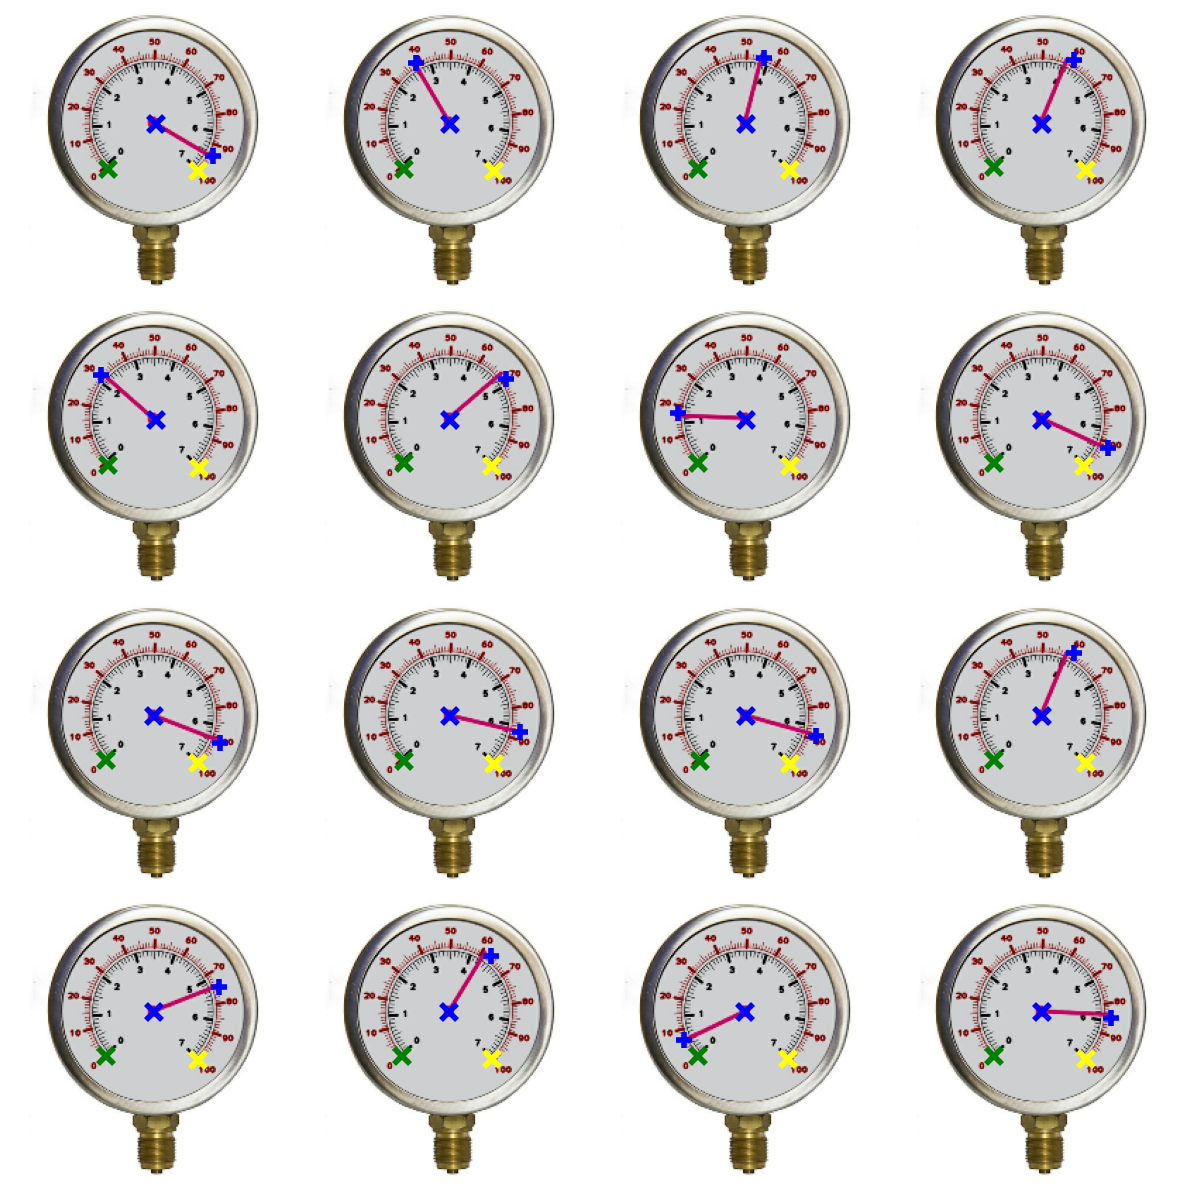

In [74]:
plot_predictions(test_input, y_hat)

# 5. Save model

In [75]:
# Save weights
model.save('gauge_value_estimator_model_200x200x3.h5')

In [76]:
# Reload model for testing
model1 = tf.keras.models.load_model('gauge_value_estimator_model_200x200x3.h5')